# Ultrasound Nerve Detection Kaggle Retrospective

This is a summary of my explorations on the brachial plexus nerve segmentation competition.

https://www.kaggle.com/c/ultrasound-nerve-segmentation


## Overview

The challenge is to use ultra-sound images to generate a mask which differentiates pixels in the images which belong to the Brachial Plexus (BP) versus those that do not. I decided that I would try using a matched filter approach to locate the BP. 

<!-- TEASER_END -->

https://en.wikipedia.org/wiki/Matched_filter

A matched filter approach seemed likely to perform well and was something I had been meaning to play around with for some time. In short the overall strategy was to cross correlate the input images with a template image, take the set of all local maxima of the correlation image and rank them according to some quality metric if the best ranked maximum exceeded some quality threshold then I would accept it.

The exact implementation of all of these steps went through significant changes during the course of the competition but the overall idea remained the same. As it turned out the correlation peaks would nearly always contain the correct BP location but designing a decent metric for ranking the associated prospective BP locations and choosing a reasonable threshold to detect when the image ought to be labeled as having no BP turned out to be more difficult than I would have imagined. In the end the pure correlation magnitude turned out to be the best performing metric I tried before the competition ended and that worked only poorly. In retrospect I think I did not give the fact that the noise in sonar/radar/ultra-sound data is multiplicative instead of addiitive the respect that it deserves. Most of the metrics I did try (least $\chi^2$, least absolute deviation, et cetera) implicitly assumed that in the case of a good detection the magnitude of the noise would be smaller relative to the magnitude of the signal when in reality the noise was strongest precisely when the signal was strongest.  


In [1]:
import os
import re
from copy import copy

import numpy as np
import skimage

%matplotlib inline
import matplotlib.pyplot as plt
import PIL

import pandas as pd
import scipy
import scipy.signal
from scipy import ndimage

from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC

from matplotlib.patches import Ellipse
from skimage.feature import peak_local_max

In [2]:
plt.rcParams.update(
    {
        "font.size":16,
        "image.cmap":"afmhot",
        "figure.figsize":(12, 5),
    }
)

# Data Pre-Processing

The ultra-sound images have high magnitude noise in them and the Brachial Plexus does not look to have significant structure at the pixel scale in the images. The type of noise encountered in these images is called speckle noise There is significant literature on attempting to de-noise images of this kind. A comparison of different de-noising techniques on a simple test image done in the paper "Speckle Noise Reduction in Medical Ultrasound Images" https://arxiv.org/pdf/1305.1344.pdf convinced me that using a simple running median filter would likely be good enough for my purposes. Since the median filter is implemented in scipy.ndimage.filters I applied that to all the input images as a pre-processing step and downsampled them to reduce the computational strain of this project down to something my laptop wouldn't have too much trouble with.

I have some experience applying median filtering to projects in stellar spectroscopy and I don't like the way that it tends to induce sharp transitions where there shouldn't be any.
I loaded in all the images median filtered on a 5x5 pixel footprint followed by a gaussian smoothing and downsampled row and column by a factor of 2. The resulting images could have been downsampled by more than a factor of 2 but I wanted to keep the downsampling rate an integer divisor of the full image size to keep translating back and forth from downsampled images to full images clean and simple.

In [17]:
nrow_full, ncol_full = 420, 580

np.random.seed(89)
train_fraction = 0.9

median_footprint_row = 5
median_footprint_col = 5
median_footprint_radius = 1.05

gaussian_smooth_scale = 2
row_downsample = 2
col_downsample = 2

pca_foreground_k = 20


13


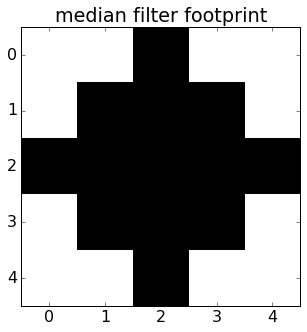

In [4]:
def get_circle_mask(shape, fractional_radius):
    xm, ym = np.meshgrid(np.linspace(-1, 1, shape[0]), np.linspace(-1, 1, shape[1]))
    return np.sqrt(xm**2+ym**2) <= fractional_radius

circle_mask = get_circle_mask(
    (median_footprint_row, median_footprint_col), 
    median_footprint_radius
)
print(np.sum(circle_mask))
plt.imshow(circle_mask, interpolation="nearest", cmap="binary")
plt.title("median filter footprint")

In [8]:
train_file_expr = "(\d+)_(\d+).tif"
tfe_pat = re.compile(train_file_expr)

train_dir = "data/train"

#create a mapping from patient to associated image numbers
patient_to_images = {}

for fname in os.listdir(train_dir):
    match = tfe_pat.match(fname)
    if match:
        patient, im_num = [int(num) for num in match.groups()]
        cl = patient_to_images.get(patient, [])
        cl.append(im_num)
        patient_to_images[patient] = cl

#sort the image numbers for each patient
for patient in patient_to_images:
    patient_to_images[patient] = sorted(patient_to_images[patient])


In [9]:
raw_preprocessor_kwargs = {
    "median_footprint":circle_mask,
    "gaussian_sigma":gaussian_smooth_scale,
    "row_downsample":row_downsample,
    "col_downsample":col_downsample,
}

def raw_preprocessor(image, median_footprint, gaussian_sigma, row_downsample, col_downsample):
    image = ndimage.filters.median_filter(image, footprint=median_footprint).astype(float)
    image = ndimage.filters.gaussian_filter(image, gaussian_sigma)
    return image[::row_downsample, ::col_downsample].copy()

def mask_preprocessor(mask, **kwargs):
    return raw_preprocessor(mask, **kwargs) > 0.5

In [10]:
def extract_mask_params(mask, row_mesh, col_mesh):
    params = {col_name:np.nan for col_name in "row col sigma_major sigma_minor theta".split()}
    row_coords = row_mesh[mask]
    if len(row_coords) == 0:
        return params
    col_coords = col_mesh[mask]
    row = np.mean(row_coords)
    col = np.mean(col_coords)
    params["row"] = row
    params["col"] = col
    delta_row = row_coords - row
    delta_col = col_coords - col
    stacked_delts = np.stack([delta_row, delta_col], 1)
    u, s, v = np.linalg.svd(stacked_delts, full_matrices=False)
    params["sigma_major"] = np.sqrt(s[0])
    params["sigma_minor"] = np.sqrt(s[1])
    principle_axis = v[0]
    theta = np.arctan2(principle_axis[1], principle_axis[0])
    params["theta"] = theta
    return params

def overplot_ellipse(
    ellipse_params,
    scale_factor = 2.1,
    ellipse_style=None, 
    ax=None,
):
    if ax is None:
        fig, ax = plt.subplots()
    if ellipse_style is None:
        ellipse_style = {"facecolor":"none", "edgecolor":"green", "lw":3, "alpha":0.8}
    
    ell_par = {}
    ell_par["xy"] = np.array([ellipse_params["col"], ellipse_params["row"]])
    ell_par["width"] = ellipse_params["sigma_minor"]*scale_factor
    ell_par["height"] = ellipse_params["sigma_major"]*scale_factor
    ell_par["angle"] = -ellipse_params["theta"]*180/np.pi
    
    ell_par.update(ellipse_style)
    ell = Ellipse(**ell_par)
    ax.add_artist(ell)
    return ax


In [11]:
nrow, ncol = nrow_full//row_downsample, ncol_full//col_downsample
imshape = (nrow, ncol)

row_coords = np.arange(nrow)
col_coords = np.arange(ncol)

row_mesh = row_coords.reshape((-1, 1))*np.ones((1, ncol))
col_mesh = np.ones((nrow, 1))*col_coords.reshape((1, -1))

In [12]:
images = []
masks = [] 
imdat = [] #image meta data

for patient in sorted(patient_to_images.keys()):
    print("processing data for patient {}".format(patient))
    im_numbers = patient_to_images[patient]
    
    cstack = []
    cstack_mask = []
    for im_num in im_numbers:
        image = PIL.Image.open("data/train/{}_{}.tif".format(patient, im_num))
        mask = PIL.Image.open("data/train/{}_{}_mask.tif".format(patient, im_num))
        cstack.append(raw_preprocessor(image, **raw_preprocessor_kwargs))
        cstack_mask.append(mask_preprocessor(mask, **raw_preprocessor_kwargs))
    
    for im_idx in range(len(im_numbers)):
        cmask = cstack_mask[im_idx]
        has_mask = np.sum(cmask) > 0
        cdict = {
            "patient":patient, 
            "im_num":im_numbers[im_idx], 
            "has_mask":has_mask,
        }
        cdict.update(extract_mask_params(cmask, row_mesh=row_mesh, col_mesh=col_mesh))
        imdat.append(cdict)
    
    images.extend(cstack)
    masks.extend(cstack_mask)

images = np.stack(images, axis=0)
masks = np.stack(masks, axis=0)
imdat = pd.DataFrame(imdat)

processing data for patient 1
processing data for patient 2
processing data for patient 3
processing data for patient 4
processing data for patient 5
processing data for patient 6
processing data for patient 7
processing data for patient 8
processing data for patient 9
processing data for patient 10
processing data for patient 11
processing data for patient 12
processing data for patient 13
processing data for patient 14
processing data for patient 15
processing data for patient 16
processing data for patient 17
processing data for patient 18
processing data for patient 19
processing data for patient 20
processing data for patient 21
processing data for patient 22
processing data for patient 23
processing data for patient 24
processing data for patient 25
processing data for patient 26
processing data for patient 27
processing data for patient 28
processing data for patient 29
processing data for patient 30
processing data for patient 31
processing data for patient 32
processing data f

# Mask Representation

Since the goal of the competition is to predict a mask segmenting the images into pixels belonging to the BP and those not it is important that we have some way of seeing where in the image the boundary lies. Although we could find and store the exact boundary of the given masks and overplot those as curves such a representation of the masks would be of limited usefulness since they would be very difficult to compare and translation to and from the closed polygon representation of the mask to the image representation would be non-trivial. Instead I opted to attempt to fit an ellipse to each mask so that I can easily carry around a rough representation of the mask as lightweight meta data and I can overplot ellipses on images.

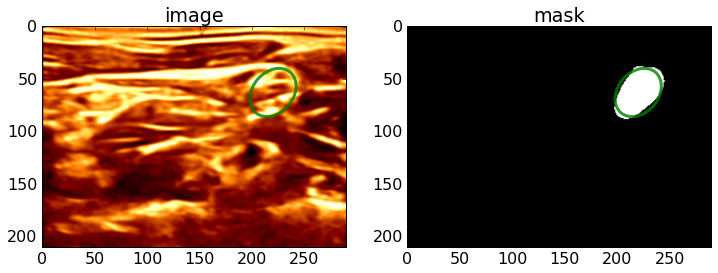

In [13]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(images[0])
axes[0].set_title("image")

axes[1].imshow(masks[0])
axes[1].set_title("mask")

overplot_ellipse(imdat.iloc[0], ax=axes[0])
overplot_ellipse(imdat.iloc[0], ax=axes[1])



# PCA Foreground Removal

In the matched filter paradigm the best filter to use is one which optimizes the signal to noise ratio of the filter. When attempting to do this it is obvious that one wants to pick templates which are as closely aligned as possible with the target signal but it is slightly less obvious that it can be at least equally important to pick filters which are nearly orthogonal to the noise in the image.

The speckle noise in these images is random and so there is no way that we can really pick characteristic examples of the measurement noise. However we can also view foreground structures which we are not attempting to detect as a form of noise. With this perspective in mind we attempt to improve the performance of our filter by extracting a PCA representation of the images with no BP mask and then using that representation to fit a foreground model to each image and subtracting that off as a pre-processing step before running our correlation filter.



In [19]:
maskless_indexes = np.where(np.logical_not(imdat["has_mask"].values))[0]
maskless_ims = images[maskless_indexes]

mean_maskless = np.mean(maskless_ims, axis=0)
reshaped_ims = maskless_ims.reshape((-1, nrow*ncol))

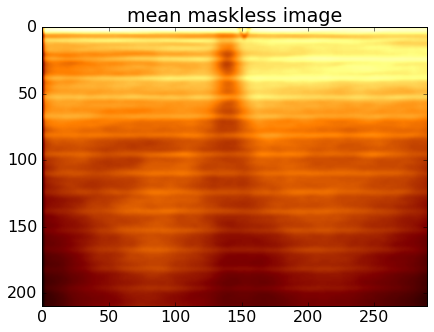

In [20]:
plt.imshow(mean_maskless)
plt.title("mean maskless image")

Doing PCA on the full image set all at once is a rather tall order and in this case it is not essential that we get the variance or the ordering of the components quite right so we have opted to chunk the PCA up into small chunks and then recombine the results at the end.



In [22]:
stacked_vs = []
#cut the pca problem up into little subproblems
n_blocks = 50
extra_sub_vectors = 5
block_size = len(reshaped_ims)//n_blocks
for i in range(n_blocks):
    u_maskless, s_maskless, v_maskless = np.linalg.svd(
        reshaped_ims[i*block_size:(i+1)*block_size]-mean_maskless.reshape((-1,)),
        full_matrices=False,
    )
    n_keep = pca_foreground_k+extra_sub_vectors
    vprod = v_maskless[:n_keep]*np.sqrt(s_maskless[:n_keep]).reshape((-1, 1))
    stacked_vs.append(vprod)

#recombine the chunks into one big pca
recomb_u, recomb_s, recomb_v = np.linalg.svd(
    np.vstack(stacked_vs), 
    full_matrices=False
)

pca_frame = recomb_v[:pca_foreground_k].copy()

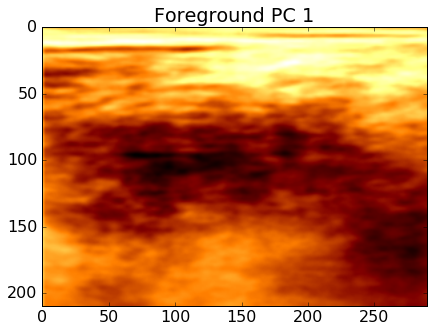

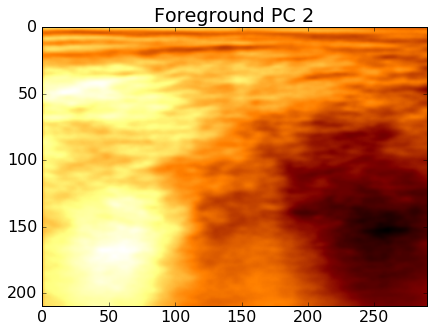

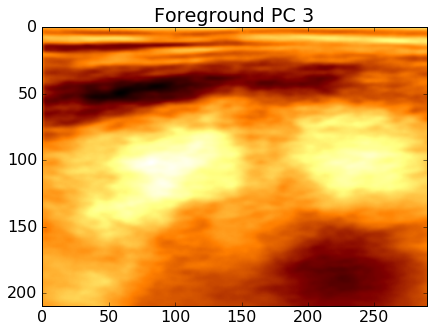

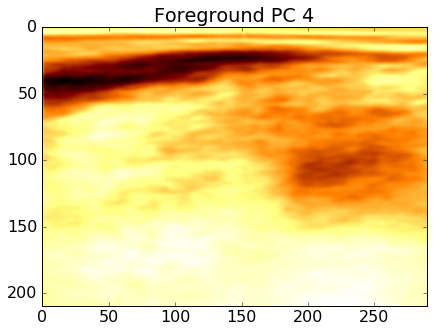

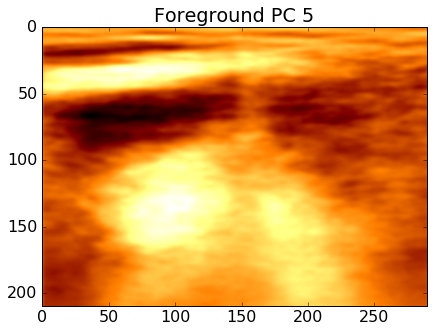

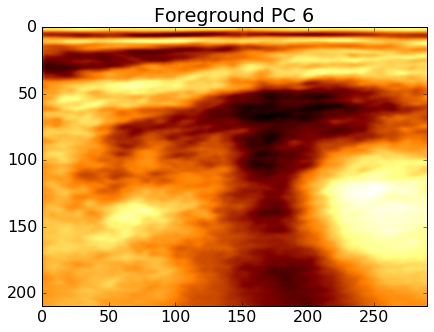

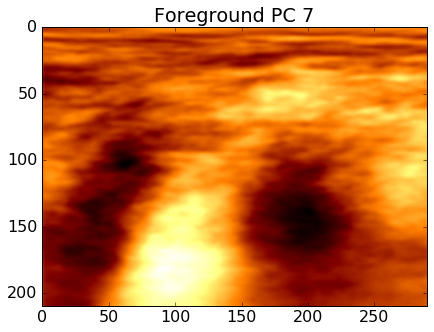

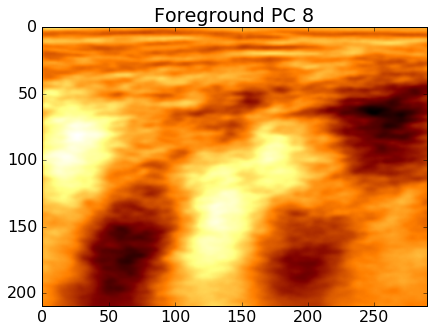

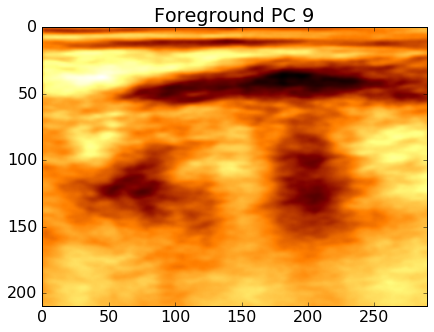

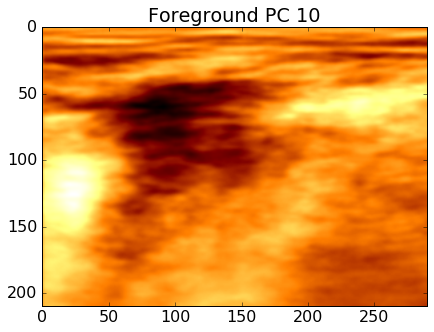

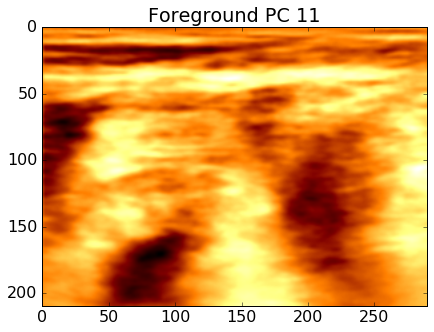

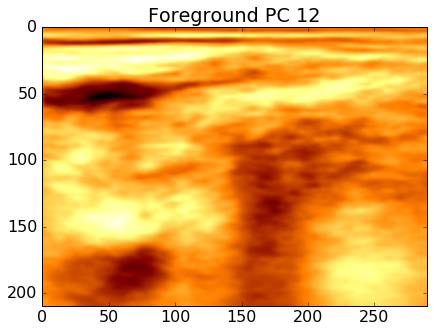

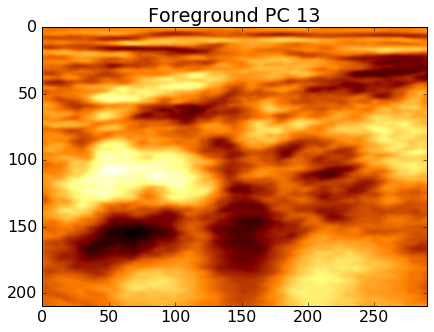

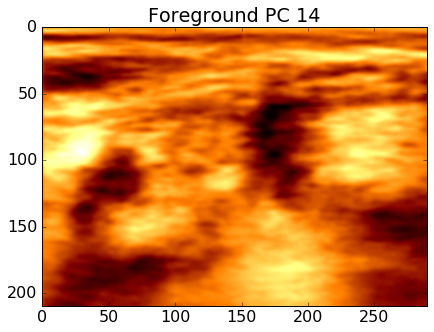

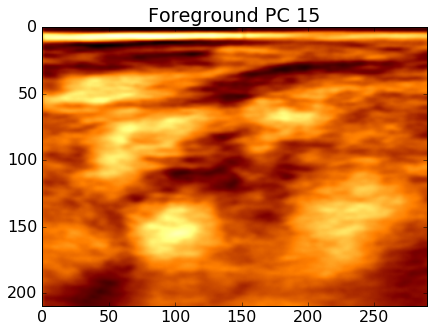

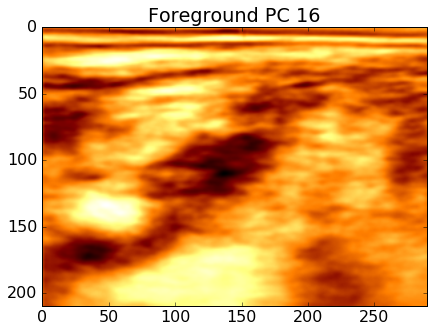

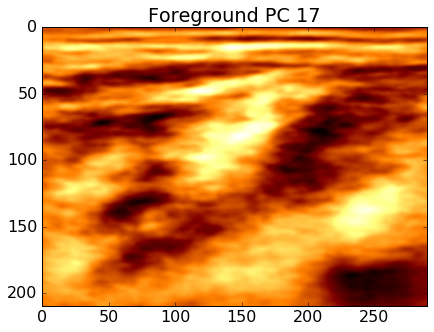

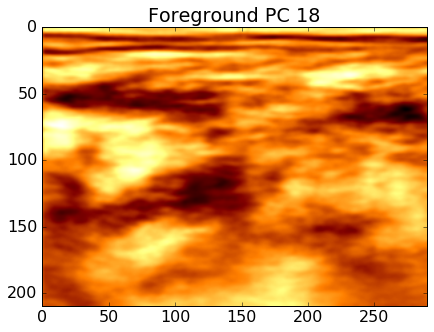

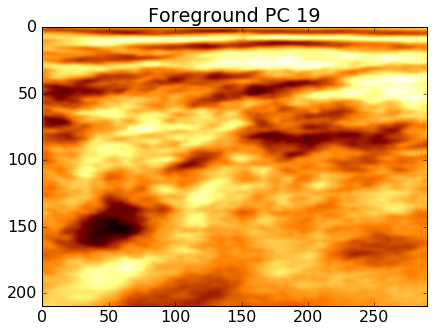

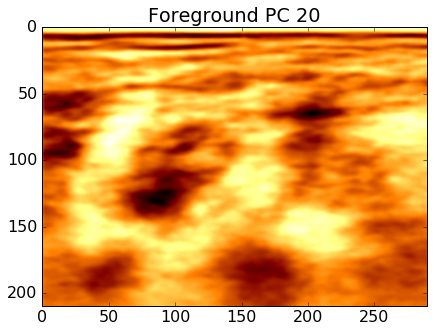

In [24]:
for i in range(pca_foreground_k):
    plt.imshow(pca_frame[i].reshape((nrow, ncol)))
    plt.title("Foreground PC {}".format(i+1))
    plt.show()

The interpretation of these images isn't clear to me but I imagine they are the result of some combination of imaging artefacts and person to person differences in internal structures that are consistently located. Removing these structures from the images as a pre-processing step helps to boost the signal of the BP correlation relative to the background.


In [29]:
def orthogonal_foreground_filter(image, frame):
    """find and remove a foreground model assuming the provided basis is orthonormal"""
    coeffs = np.dot(frame, image.reshape((-1,)))
    foreground = np.dot(frame.transpose(), coeffs)
    return image - foreground.reshape(image.shape), foreground.reshape(image.shape)

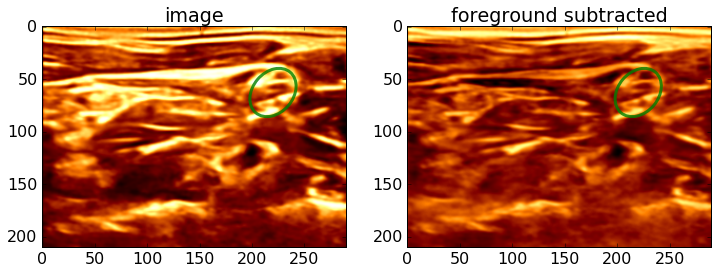

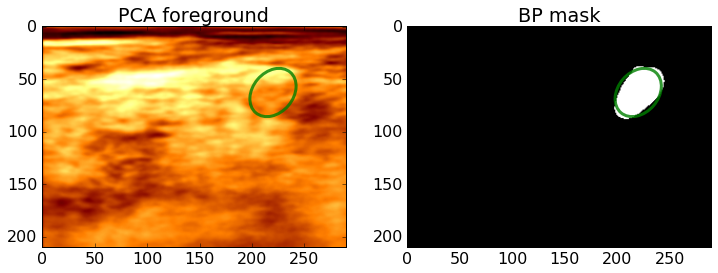

In [32]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(images[0])
fim, fore = orthogonal_foreground_filter(images[0], pca_frame)
axes[1].imshow(fim)
for ax in axes:
    overplot_ellipse(imdat.iloc[0], ax=ax)
axes[0].set_title("image")
axes[1].set_title("foreground subtracted")
    
fig, axes = plt.subplots(1, 2)
axes[0].imshow(fore)
axes[1].imshow(masks[0])
for ax in axes:
    overplot_ellipse(imdat.iloc[0], ax=ax)
    
axes[0].set_title("PCA foreground")
axes[1].set_title("BP mask")

As you can see from this example the PCA foreground is relatively smooth and tends to attenuate the intensities of places in the image which are not associated to the BP. The structure of the PCA could in principle also attenuate the BP signal but since we have kept all images labeled as having a BP present out it is no surprise that the attenuation of the BP image signal is much less. In practice the application of the PCA foreground filter did boost performance somewhat but it turned out not to make as big of a difference as I would have liked.

# BP stamp analysis

Now we turn an eye to the analysis of the structure of pixels labeled as belonging to the BP. Early in the competition we attempted to normalize all images to a common scaling and rotation and to then analyze the structure of the images jointly. However the morphology of the BP turned out to be more complex than we had anticipated and the task of appropriately normalizing the images and then learning an appropriate morphological structure turned out to be more trouble than it was worth. Instead 

In [40]:
stamp_nrow = 50
stamp_ncol = 70
stamp_shape = (stamp_nrow, stamp_ncol)

def image_preconditioner(image):
    image - mean_maskless
    im = orthogonal_foreground_filter(image, pca_frame)[0]
    im -= np.mean(im)
    return im

def get_stamp_bounding_indices(row, col):
    row = int(np.around(row))
    col = int(np.around(col))
    lbr = max(0, row - stamp_nrow//2)
    ubr = min(nrow, row + stamp_nrow//2)
    
    lbc = max(0, col - stamp_ncol//2)
    ubc = min(ncol, col + stamp_ncol//2)
    return lbr, ubr, lbc, ubc


maskful_indexes = np.where(imdat.has_mask.values)[0]
stamps = []
stamp_masks = []

for im_idx in maskful_indexes:
    precon_im = image_preconditioner(images[im_idx])
    crow = imdat.iloc[im_idx]["row"]
    ccol = imdat.iloc[im_idx]["col"]
    lbr, ubr, lbc, ubc = get_stamp_bounding_indices(crow, ccol)
    stamp = precon_im[lbr:ubr, lbc:ubc]
    if stamp.shape != (stamp_nrow, stamp_ncol):
        print("dropping incomplete stamp")
    else:
        stamps.append(stamp)
        stamp_masks.append(masks[im_idx][lbr:ubr, lbc:ubc])
        
stamps = np.stack(stamps, axis=0)
stamp_masks = np.stack(stamp_masks, axis=0)

dropping incomplete stamp


# Sample Masked BP images

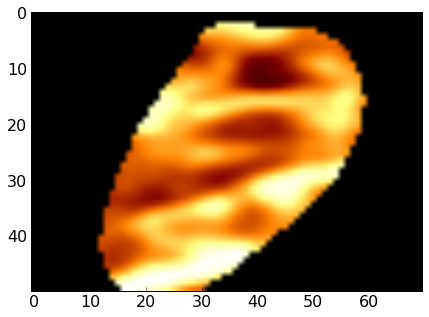

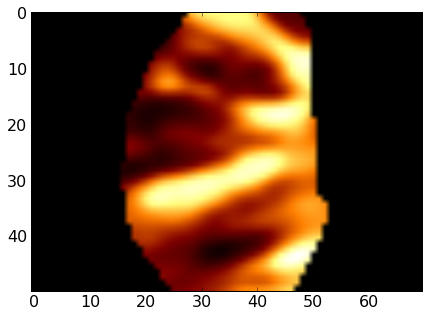

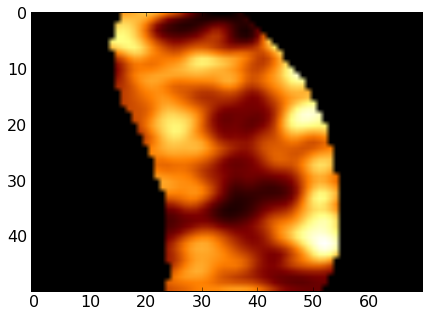

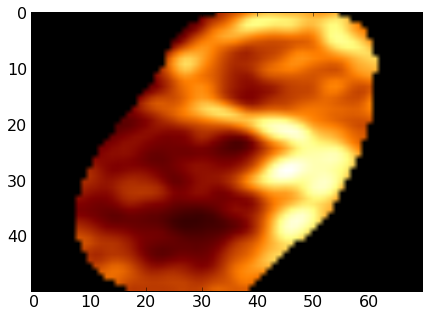

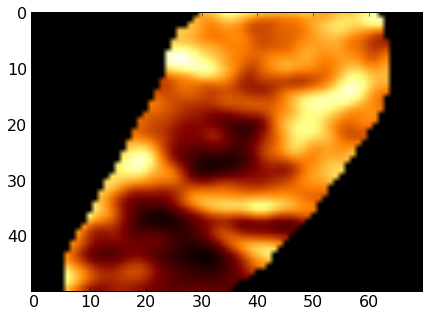

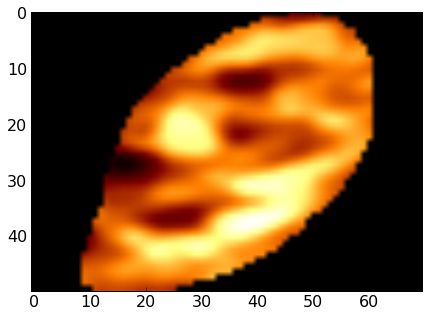

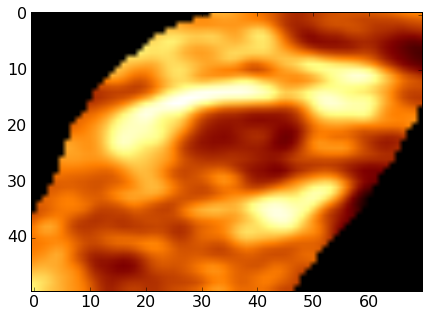

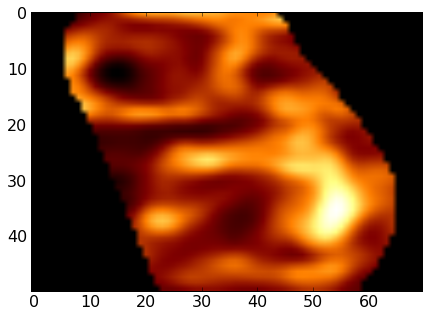

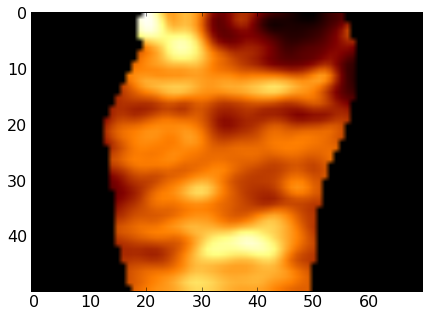

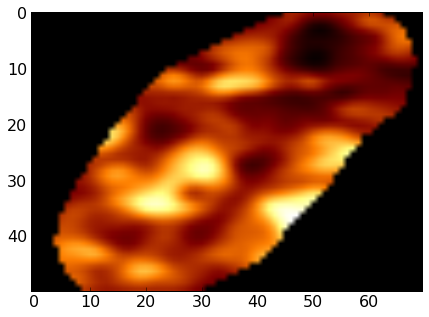

In [41]:
for i in range(0, 1000, 100):
    plt.imshow(np.where(stamp_masks[i], stamps[i], np.min(stamps[i])))
    plt.show()


As you can see there is a large amount of variety in the appearance of the BP. My first approach was to focus on the mask properties and group images on the basis of some metrics related to the length of the principal axes of the extracted ellipse and its angle of rotation. However this approach ended up working relatively poorly and depending on the exact values involved sometimes the physical orientation of the major and minor axes of the ellipse would flip giving a very different sort of interpretation of the grouping. In the end I found that a much better idea was to simply directly cluster on the masked BP images and to then use the resulting k-mean centroids as my correlation templates.

In [42]:
masked_stamps = stamps*stamp_masks
masked_stamps = masked_stamps.reshape((-1, stamp_nrow*stamp_ncol))

from scipy.cluster import vq
n_clusters = 7
kmres = vq.kmeans(masked_stamps, n_clusters)

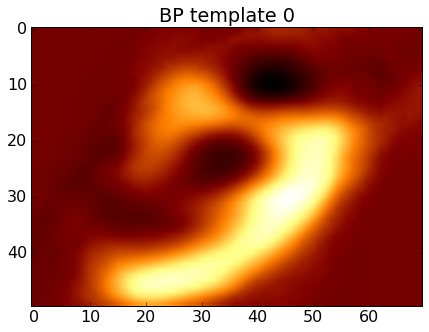

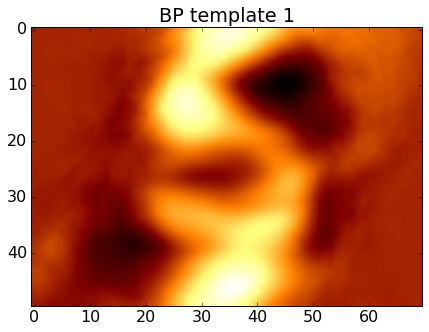

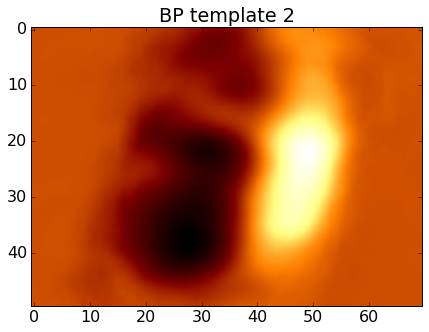

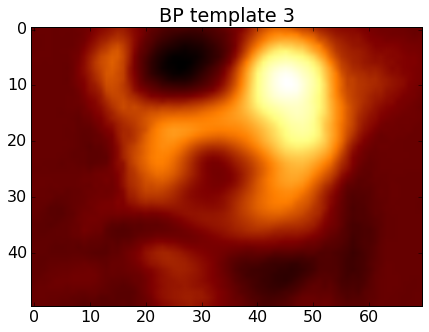

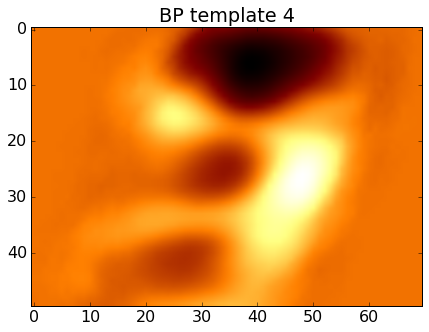

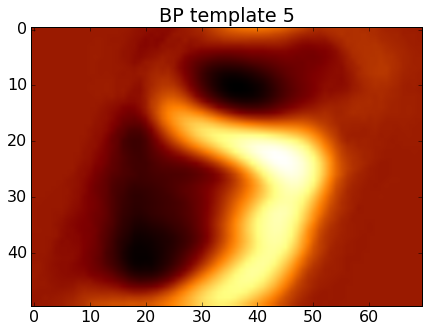

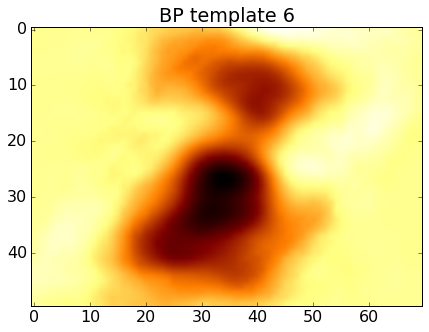

In [45]:
centroids = kmres[0]
for cluster_idx in range(n_clusters):
    plt.imshow(centroids[cluster_idx].reshape((stamp_nrow, stamp_ncol,)))
    plt.title("BP template {}".format(cluster_idx))
    plt.show()

# Associating Masks to Centroids

Each of these centroids tends to correspond to a very particular mask shape and taking the average of all of the masks belonging to one centroid gives us a pretty good guess for the mask we ought to center up at the location of a prospective BP detection given by any of these templates.

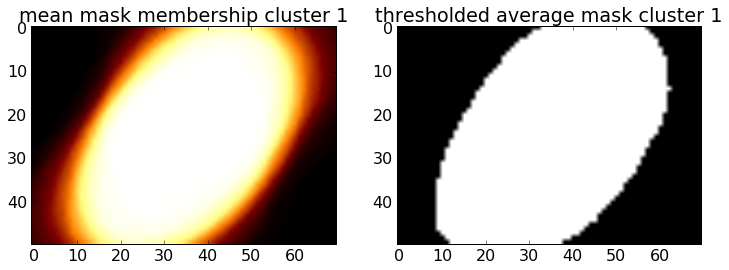

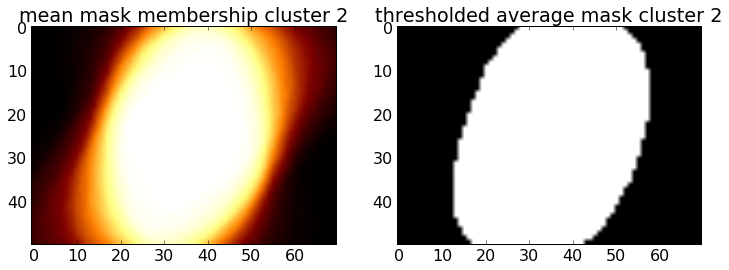

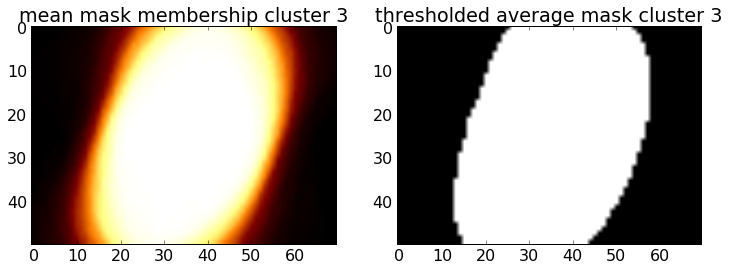

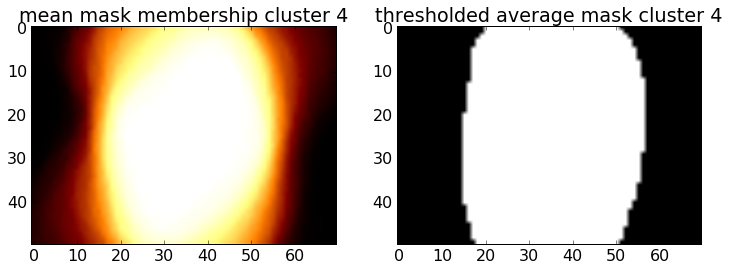

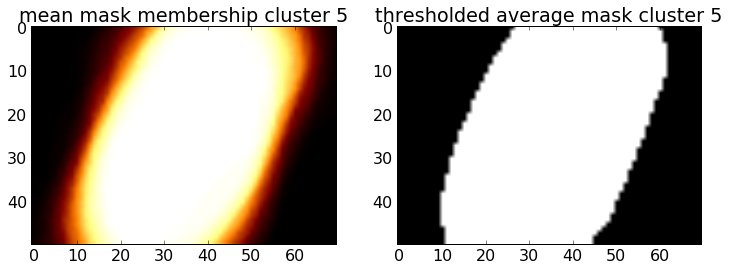

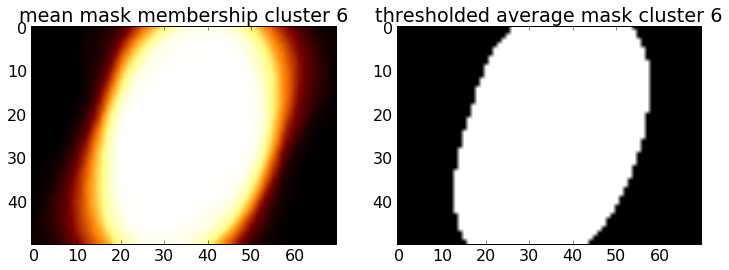

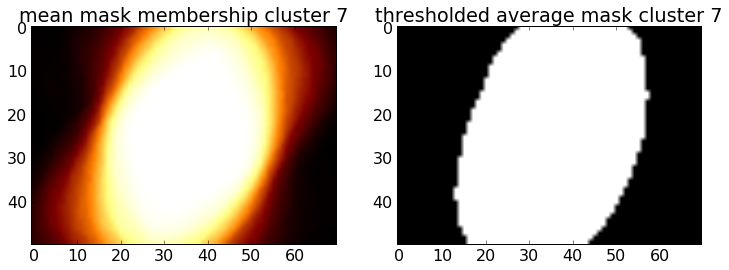

In [52]:
cluster_labels, dists = vq.vq(masked_stamps, centroids)

cluster_mean_stamp_masks = {}
cluster_masks = {}
for cluster_idx in range(n_clusters):
    im_indexes = np.where(cluster_labels == cluster_idx)[0]
    msm = np.mean(stamp_masks[im_indexes], axis=0).reshape(stamp_shape)
    cluster_mean_stamp_masks[cluster_idx] = msm
    cluster_masks[cluster_idx] = msm > 0.5

for cluster_idx in range(n_clusters):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(cluster_mean_stamp_masks[cluster_idx])
    axes[1].imshow(cluster_masks[cluster_idx])
    axes[0].set_title("mean mask membership cluster {}".format(cluster_idx+1))
    axes[1].set_title("thresholded average mask cluster {}".format(cluster_idx+1))
    plt.show()

# Detection and Prospective Ranking

Here we finally get to the heavy lifting where we correlate the images with our templates. The local maxima of each correlation image become prospective BP detections and for each one we extract various metrics which are intended to help us later rank and filter the detections to ensure that we get good detections.

In [47]:
#helpful metrics possibly with a sign flip to make higher better
def chi_metric(data, model, resids, mask):
    "square root of chi square"
    return np.sqrt(np.sum((resids*mask)**2))

def sad_metric(data, model, resids, mask):
    "sum of absolute deviations"
    return np.sum(np.abs(resids*mask))

def data_variance_metric(data, model, resids, mask):
    "total variance"
    return np.sum((data*mask)**2)

def residual_variance_metric(data, model, resids, mask):
    "residual variance"
    return np.sum((resids*mask)**2)

def mad_metric(data, model, resids, mask):
    "mean absolute deviation"
    return np.mean(np.abs(resids[mask]))


class PlexusModel(object):
    
    def __init__(
        self,
        matched_filter,
        fitting_frame,
        mask,
        fit_metrics,
    ):
        self.matched_filter = matched_filter
        self.fitting_frame  = fitting_frame
        self.mask = mask
        self.fit_metrics = fit_metrics
    
    def get_localizations(self, image):
        conv_im = scipy.signal.fftconvolve(image, self.matched_filter, mode="same")
        peaks = peak_local_max(
            conv_im,
            num_peaks=10,
        )
        peak_vals = [conv_im[prow, pcol] for prow, pcol in peaks]
        
        stamp_shape = self.matched_filter.shape
        fit_metric_values = {metric_name:[] for metric_name in self.fit_metrics}
        for peak_idx in range(len(peak_vals)):
            prow, pcol = peaks[peak_idx]
            lbr, ubr, lbc, ubc = get_stamp_bounding_indices(prow, pcol)
            cstamp = image[lbr:ubr, lbc:ubc]
            if cstamp.shape != stamp_shape:
                best_model = None
            else:
                coeffs = np.linalg.lstsq(self.fitting_frame, cstamp.reshape((-1,)))[0]
                best_model = np.dot(self.fitting_frame, coeffs).reshape(stamp_shape)
                #import pdb; pdb.set_trace()
            for metric_name in self.fit_metrics:
                if best_model is None:
                    metric_value = np.nan
                else:
                    resids = cstamp-best_model
                    metric_func = self.fit_metrics[metric_name]
                    metric_value = metric_func(cstamp, best_model, resids, self.mask)
                fit_metric_values[metric_name].append(metric_value)
        
        result_dict = dict(
            peaks = peaks,
            peak_vals = peak_vals,
            fit_metrics = fit_metric_values,
        )
        return result_dict

In [53]:
bp_models = []
for cluster_idx in range(n_clusters):
    centroid = centroids[cluster_idx].reshape(stamp_shape)
    bp_structure = centroid*cluster_masks[cluster_idx]
    bp_structure /= np.sqrt(np.sum(bp_structure**2))
    bpmod = PlexusModel(
        matched_filter=bp_structure[::-1, ::-1].copy(),
        fitting_frame=bp_structure.reshape((-1, 1)),
        mask=cluster_masks[cluster_idx],
        fit_metrics={
            "chi":chi_metric,
            "sad":sad_metric,
            "data_var":data_variance_metric,
            "resid_var":residual_variance_metric,
            "mad":mad_metric,
        },
    )
    bp_models.append(bpmod)

# Example Detection 

Looking at the correlation images of one of the images with a BP present we can see that the algorithm does in fact mark the proper location of the BP but that there are also lots of points with spurious high correlations. I would have thought that figuring out which of these prospective locations was best would have been a relatively easy task. But it turned out that getting to this point was the easy part and designing a good way to rank and filter these prospective detections was very difficult.

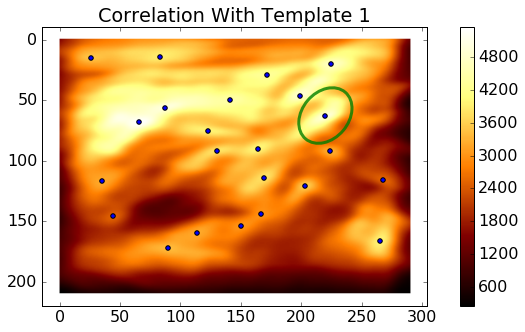

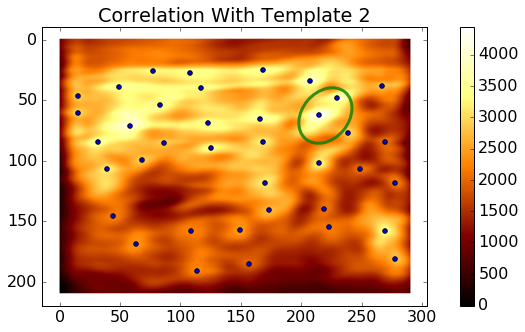

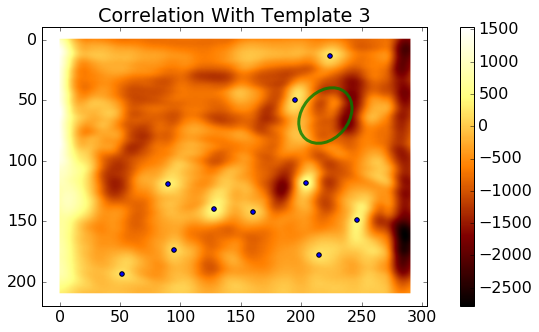

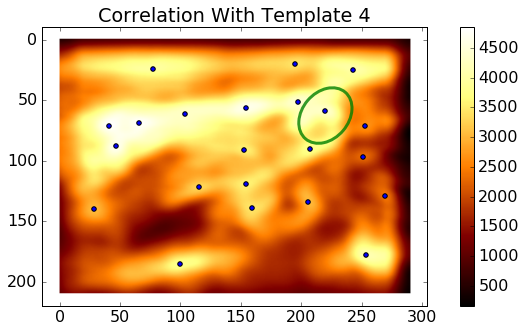

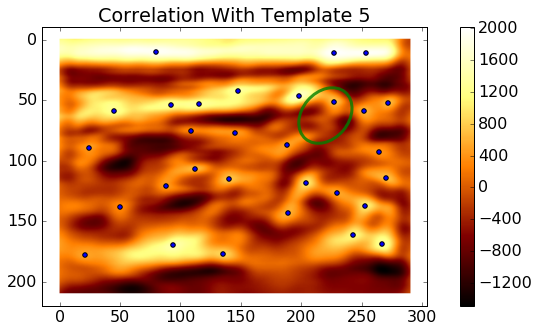

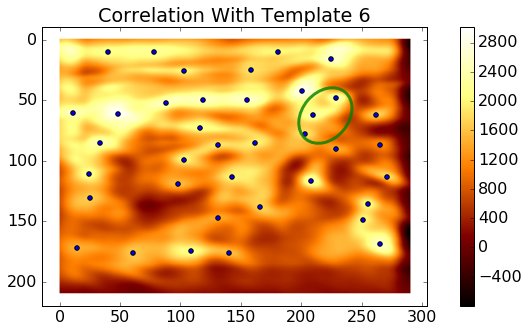

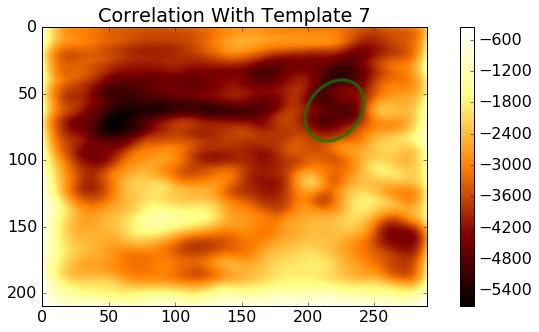

In [56]:
im_idx = maskful_indexes[0]
cim = images[im_idx]

for i in range(n_clusters):
    conv_im = scipy.signal.fftconvolve(
        cim, 
        bp_models[i].matched_filter, 
        mode="same"
    )
    fig, ax = plt.subplots()
    plt.imshow(conv_im)
    plt.colorbar()
    overplot_ellipse(imdat.iloc[im_idx], ax=ax)
    
    maxima = peak_local_max(conv_im)
    plt.scatter(maxima[:, 1], maxima[:, 0])
    plt.title("Correlation With Template {}".format(i+1))
    plt.show()

# Final Thoughts

The true mask centroid is generally within about 2-3 pixels of the nearest template correlation maxima. In this notebook I haven't split the data into a train and validation split but this remains true even when you enforce such a split. This certainly means that my model could have benefitted from a higher degree of flexibility, however the simplest means of boosting flexibility was increasing the number of k-means centroids but this rapidly causes the centroids to become highly degenerate with each other and tended to give poorer model performance instead of better.

Although I am not willing to say that my idea of attempting to come up with a good prospective detection ranking metric was a bad one it certainly didn't perform well in this case. Probably a superior option would have been to use a template driven detection algorithm propose BP locations and then to train a flexible model for accepting or rejecting prospective samples. The natural classifier would of course be a convolutional neural net but I really wanted to try and get a good solution to this problem without recourse to CNN's just to see how well I could do. 
 